In [1]:
import random
import numpy
import chainer

def reset_seed(seed=0):
    random.seed(seed)
    numpy.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed(0)

/Users/tatsuki/.pyenv/versions/3.7.0/lib/python3.7/site-packages/chainer/_environment_check.py:38: UserWarning: Accelerate has been detected as a NumPy backend library.
vecLib, which is a part of Accelerate, is known not to work correctly with Chainer.
We recommend using other BLAS libraries such as OpenBLAS.
For details of the issue, please see
https://docs.chainer.org/en/stable/tips.html#mnist-example-does-not-converge-in-cpu-mode-on-mac-os-x.

Also note that Chainer does not officially support Mac OS X.
Please use it at your own risk.

  ''')  # NOQA


In [2]:
# chainer-testと同じ
# データの用意

from chainer.datasets import mnist
from chainer.datasets import split_dataset_random
from chainer import iterators

import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()

        # パラメータを持つ層の登録
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(n_mid_units, n_mid_units)
            self.l3 = L.Linear(n_mid_units, n_out)

    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

train_val, test = mnist.get_mnist()
train, valid = split_dataset_random(train_val, 50000, seed=0)

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(valid, batchsize, False, False)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

gpu_id = -1  # CPUを用いたい場合は、-1を指定してください

net = MLP()

if gpu_id >= 0:
    net.to_gpu(gpu_id)

In [3]:
from chainer import training
from chainer import optimizers

gpu_id = -1  # CPUを使いたい場合は-1を指定してください

# ネットワークをClassifierで包んで、ロスの計算などをモデルに含める
net = L.Classifier(net)

# 最適化手法の選択
optimizer = optimizers.SGD(lr=0.01).setup(net)

# UpdaterにIteratorとOptimizerを渡す
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

In [4]:
max_epoch = 10

# TrainerにUpdaterを渡す
trainer = training.Trainer(
    updater, (max_epoch, 'epoch'), out='mnist_result')

In [5]:
from chainer.training import extensions
import numpy as np

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(valid_iter, net, device=gpu_id), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'l1/W/data/std', 'elapsed_time']))
trainer.extend(extensions.ParameterStatistics(net.predictor, {'std': np.std}))
trainer.extend(extensions.PlotReport(['l1/W/data/std'], x_key='epoch', file_name='std.png'))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [6]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  l1/W/data/std  elapsed_time
1           1.61796     0.616089       0.879348       0.812797                          9.67137       
2           0.646582    0.845488       0.510509       0.866594                          19.2831       
3           0.455697    0.878626       0.411969       0.887955                          28.5841       
4           0.387224    0.893842       0.365281       0.897449                          37.2138       
5           0.351236    0.901574       0.338854       0.904272                          46.6381       
6           0.32746     0.906711       0.318929       0.911195                          54.4967       
7           0.310047    0.910666       0.304985       0.914062                          62.5681       
8           0.295816    0.914563       0.291421       0.917326                          70.6252       
9           0.283112    0.918638       0.281749       0.919502             

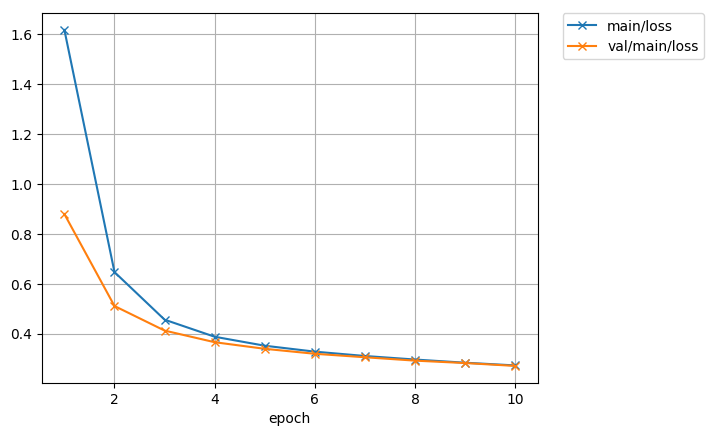

In [10]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

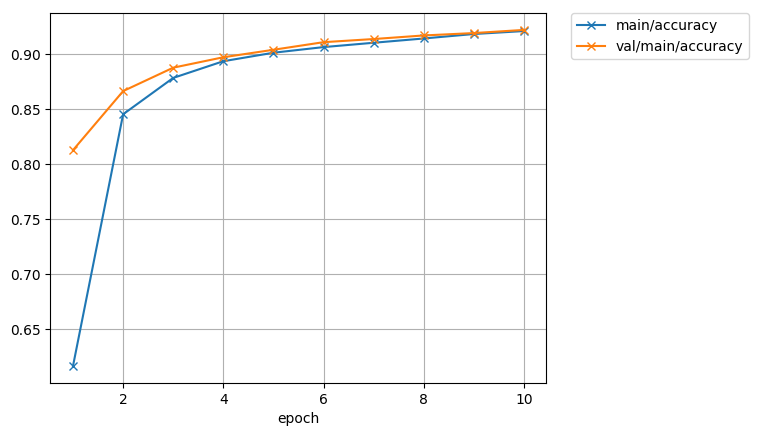

In [9]:
Image(filename='mnist_result/accuracy.png')

In [15]:
%%bash
dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

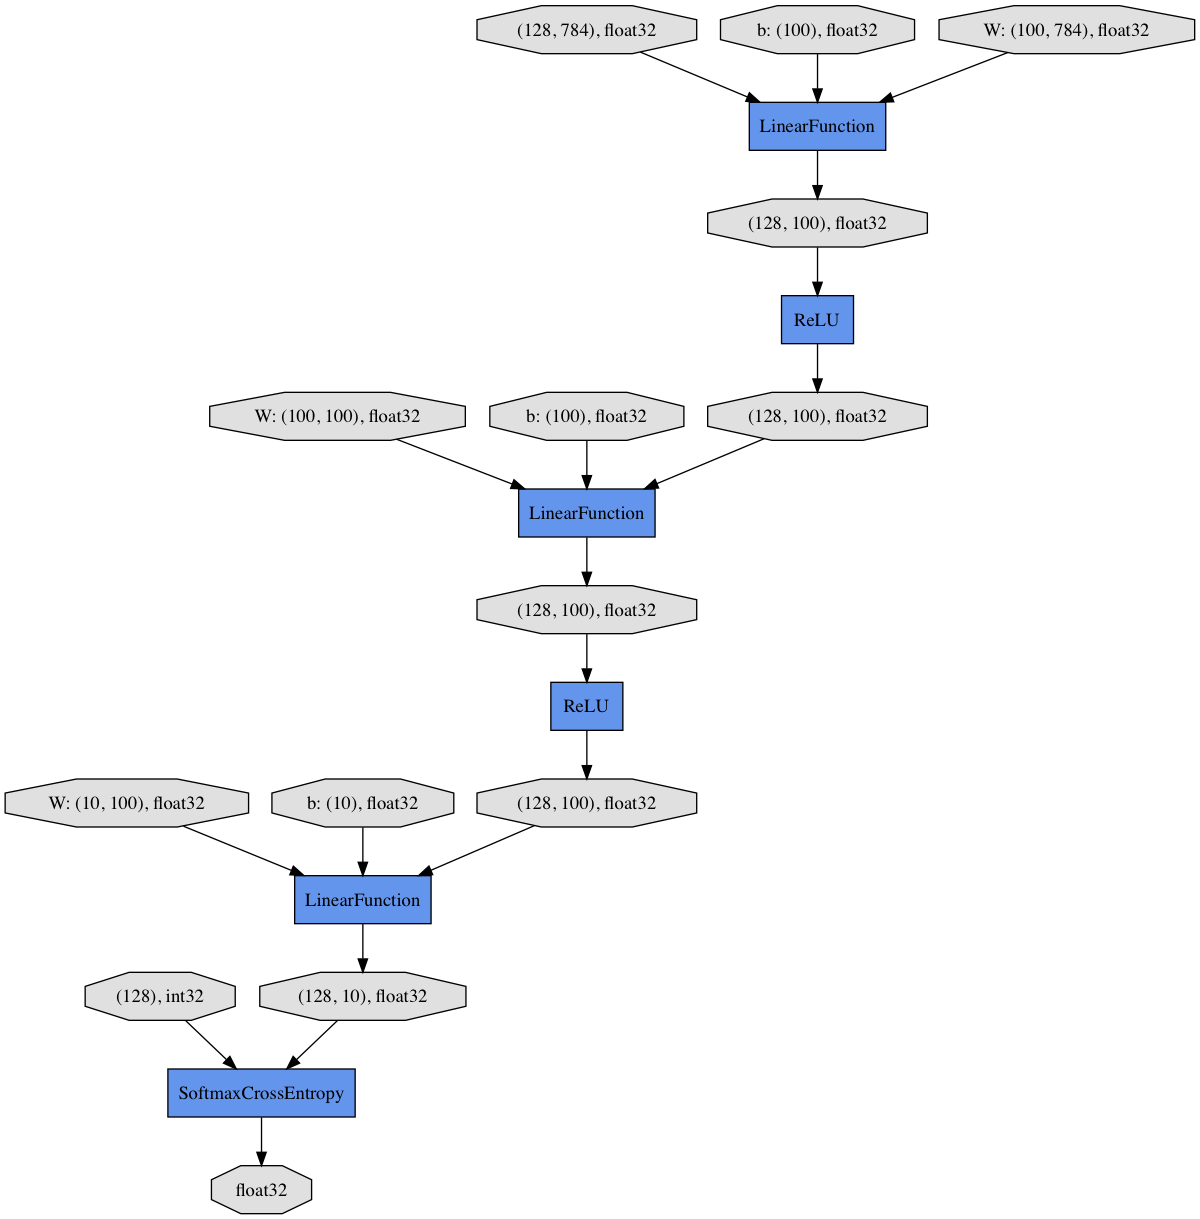

In [16]:
Image(filename='mnist_result/cg.png')

In [17]:
test_evaluator = extensions.Evaluator(test_iter, net, device=gpu_id)
results = test_evaluator()
print('Test accuracy:', results['main/accuracy'])

Test accuracy: 0.9285007911392406


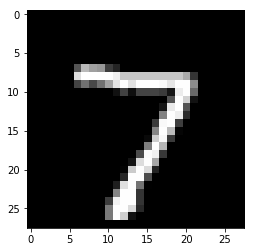

予測ラベル: 7


In [21]:
from chainer import serializers
from chainer.cuda import to_cpu

%matplotlib inline
import matplotlib.pyplot as plt

reset_seed(0)

infer_net = MLP()
serializers.load_npz(
    'mnist_result/snapshot_epoch-10',
    infer_net, path='updater/model:main/predictor/')

if gpu_id >= 0:
    infer_net.to_gpu(gpu_id)

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()

x = infer_net.xp.asarray(x[None, ...])
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y = infer_net(x)
y = to_cpu(y.array)

print('予測ラベル:', y.argmax(axis=1)[0])